In [1]:
import rasterio
import numpy as np

def calculate_ndvi(red_band_path, nir_band_path):
    # Open the Red and NIR band files 
    with rasterio.open(red_band_path) as red_src:
        red = red_src.read(1).astype('float32')
    with rasterio.open(nir_band_path) as nir_src:
        nir = nir_src.read(1).astype('float32')
        
    # Avoid division by zero
    np.seterr(divide='ignore', invalid='ignore')
    
    # Calculate NDVI
    ndvi = (nir - red) / (nir + red)
    
    # Mask background areas
    ndvi[np.isnan(ndvi)] = -1  # Set background pixels to -1 or any other value for masking
    return ndvi

# Paths to the Red and NIR bands for each year
red_band_2023_path = "LC09_L2SP_191055_20231003_20231004_02_T1_SR_B4.TIF"
nir_band_2023_path = "LC09_L2SP_191055_20231003_20231004_02_T1_SR_B5.TIF"
red_band_2024_path = "LC09_L1GT_191055_20241005_20241005_02_T2_B4.TIF"
nir_band_2024_path = "LC09_L1GT_191055_20241005_20241005_02_T2_B5.TIF"

# Calculate NDVI for each year
ndvi_2023 = calculate_ndvi(red_band_2023_path, nir_band_2023_path)
ndvi_2024 = calculate_ndvi(red_band_2024_path, nir_band_2024_path)


In [2]:
def classify_ndvi(ndvi):
    # Define an array with the same shape as the NDVI array
    classified = np.zeros(ndvi.shape, dtype=np.int32)
    
    # Apply classification thresholds
    classified[(ndvi >= -1) & (ndvi < 0.2)] = 1  # Bare soil
    classified[(ndvi >= 0.2) & (ndvi < 0.5)] = 2  # Sparse vegetation
    classified[(ndvi >= 0.5) & (ndvi < 0.7)] = 3  # Moderate vegetation
    classified[(ndvi >= 0.7)] = 4  # Dense vegetation
    
    return classified

# Classify NDVI values for each year
ndvi_classified_2023 = classify_ndvi(ndvi_2023)
ndvi_classified_2024 = classify_ndvi(ndvi_2024)


In [3]:
# Calculate the difference in NDVI values between 2024 and 2023
ndvi_difference = ndvi_2024 - ndvi_2023

# Define thresholds for visualization purposes (for example, slight increase/decrease)
increase_threshold = 0.1  
decrease_threshold = -0.1  

# Apply classification to interpret changes
ndvi_change = np.zeros(ndvi_difference.shape, dtype=np.int32)
ndvi_change[ndvi_difference > increase_threshold] = 1   # Significant vegetation increase
ndvi_change[ndvi_difference < decrease_threshold] = -1  # Significant vegetation decrease
ndvi_change[(ndvi_difference <= increase_threshold) & (ndvi_difference >= decrease_threshold)] = 0  # No significant change


ValueError: operands could not be broadcast together with shapes (7731,7581) (7731,7591) 

In [4]:
# Find the minimum dimensions to crop both arrays
min_rows = min(ndvi_2023.shape[0], ndvi_2024.shape[0])
min_cols = min(ndvi_2023.shape[1], ndvi_2024.shape[1])

# Crop both NDVI arrays to the minimum dimensions
ndvi_2023_cropped = ndvi_2023[:min_rows, :min_cols]
ndvi_2024_cropped = ndvi_2024[:min_rows, :min_cols]

# Calculate the NDVI difference on the cropped arrays
ndvi_difference = ndvi_2024_cropped - ndvi_2023_cropped


In [5]:
import rasterio
import fiona
from rasterio.mask import mask

def clip_ndvi_to_aoi(ndvi_array, aoi_path, reference_path):
    # Open the AOI shapefile
    with fiona.open(aoi_path, "r") as shapefile:
        aoi_geometries = [feature["geometry"] for feature in shapefile]
    
    # Open a reference image to use its transform and nodata value
    with rasterio.open(reference_path) as ref_src:
        # Clip the NDVI array using AOI geometries
        out_image, out_transform = mask(ref_src, aoi_geometries, crop=True, filled=False)
        
        # Apply the mask to the NDVI array
        clipped_ndvi = ndvi_array[:out_image.shape[1], :out_image.shape[2]]
        clipped_ndvi[out_image[0] == ref_src.nodata] = np.nan  # Mask out nodata areas

    return clipped_ndvi

# Paths for AOI and reference images for each year
aoi_path = "lagos.shp"
red_band_2023_path = "LC09_L2SP_191055_20231003_20231004_02_T1_SR_B4.TIF"

# Clip the NDVI arrays
ndvi_2023_clipped = clip_ndvi_to_aoi(ndvi_2023, aoi_path, red_band_2023_path)
ndvi_2024_clipped = clip_ndvi_to_aoi(ndvi_2024, aoi_path, red_band_2023_path)

# Calculate NDVI difference on clipped arrays
ndvi_difference_clipped = ndvi_2024_clipped - ndvi_2023_clipped


ValueError: Input shapes do not overlap raster.

In [ ]:
import pyproj
from shapely.geometry import shape, mapping
from fiona import open as fiona_open
from fiona.transform import transform_geom

def reproject_aoi(aoi_path, target_crs):
    with fiona_open(aoi_path, "r") as shapefile:
        # Get the current CRS of the AOI
        aoi_crs = shapefile.crs
        geometries = [feature["geometry"] for feature in shapefile]

        # Reproject each geometry
        reprojected_geometries = [
            transform_geom(aoi_crs, target_crs, geometry) for geometry in geometries
        ]
    return reprojected_geometries


In [6]:
reprojected_geometries = reproject_aoi(aoi_path, target_crs="EPSG:32637")  # Replace with your Landsat CRS

def clip_ndvi_to_aoi(ndvi_array, aoi_geometries, reference_path):
    # Open a reference image to use its transform and nodata value
    with rasterio.open(reference_path) as ref_src:
        # Clip the NDVI array using AOI geometries
        out_image, out_transform = mask(ref_src, aoi_geometries, crop=True, filled=False)
        
        # Apply the mask to the NDVI array
        clipped_ndvi = ndvi_array[:out_image.shape[1], :out_image.shape[2]]
        clipped_ndvi[out_image[0] == ref_src.nodata] = np.nan  # Mask out nodata areas

    return clipped_ndvi


NameError: name 'reproject_aoi' is not defined

In [7]:
import rasterio
from rasterio.mask import mask
import numpy as np
import fiona

def clip_band_to_aoi(band_path, aoi_path):
    with rasterio.open(band_path) as src:
        with fiona.open(aoi_path, "r") as shapefile:
            aoi_geometries = [feature["geometry"] for feature in shapefile]
        
        # Mask the band using the AOI geometries
        out_image, out_transform = mask(src, aoi_geometries, crop=True)
        out_image = out_image[0].astype('float32')  # Convert to 2D array and float for NDVI calculation
        out_image[out_image == src.nodata] = np.nan  # Mask out nodata values
    
    return out_image

# Paths to AOI and Red/NIR bands for each year
aoi_path = "ikeja_dissolve.shp"
red_band_2023_path = "LC09_L2SP_191055_20231003_20231004_02_T1_SR_B4.TIF"
nir_band_2023_path = "LC09_L2SP_191055_20231003_20231004_02_T1_SR_B5.TIF"
red_band_2024_path = "LC09_L1GT_191055_20241005_20241005_02_T2_B4.TIF"
nir_band_2024_path = "LC09_L1GT_191055_20241005_20241005_02_T2_B5.TIF"

# Clip Red and NIR bands for each year
red_2023_clipped = clip_band_to_aoi(red_band_2023_path, aoi_path)
nir_2023_clipped = clip_band_to_aoi(nir_band_2023_path, aoi_path)
red_2024_clipped = clip_band_to_aoi(red_band_2024_path, aoi_path)
nir_2024_clipped = clip_band_to_aoi(nir_band_2024_path, aoi_path)

# Calculate NDVI for each year using the clipped bands
ndvi_2023_clipped = (nir_2023_clipped - red_2023_clipped) / (nir_2023_clipped + red_2023_clipped)
ndvi_2024_clipped = (nir_2024_clipped - red_2024_clipped) / (nir_2024_clipped + red_2024_clipped)

# Calculate the NDVI difference
ndvi_difference_clipped = ndvi_2024_clipped - ndvi_2023_clipped



ValueError: Input shapes do not overlap raster.

In [8]:
import rasterio
import fiona


with rasterio.open(red_band_2023_path) as src:
    print("Raster CRS:", src.crs)
    
with fiona.open(aoi_path, "r") as shapefile:
    print("AOI CRS:", shapefile.crs)


Raster CRS: EPSG:32631
AOI CRS: {'init': 'epsg:4326'}


In [9]:
import fiona
from fiona.transform import transform_geom

def reproject_aoi(aoi_path, target_crs):
    with fiona.open(aoi_path, "r") as shapefile:
        original_crs = shapefile.crs
        geometries = [transform_geom(original_crs, target_crs, feature["geometry"]) for feature in shapefile]
    return geometries

# Reproject the AOI to match the raster’s CRS
with rasterio.open(red_band_2023_path) as src:
    raster_crs = src.crs
reprojected_geometries = reproject_aoi(aoi_path, target_crs=raster_crs)


AttributeError: 'rasterio.crs.CRS' object has no attribute 'encode'

Exception ignored in: 'fiona._transform._crs_from_crs'
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\envs\spatialds\lib\site-packages\fiona\transform.py", line 92, in transform_geom
    return _transform_geom(
AttributeError: 'rasterio.crs.CRS' object has no attribute 'encode'


In [10]:
import rasterio
import fiona
from rasterio.warp import transform_geom

# Load raster CRS
with rasterio.open(red_band_2023_path) as src:
    raster_crs = src.crs
    print("Raster CRS:", raster_crs)

# Load AOI CRS
with fiona.open(aoi_path, "r") as shapefile:
    aoi_crs = shapefile.crs
    print("AOI CRS:", aoi_crs)


Raster CRS: EPSG:32631
AOI CRS: {'init': 'epsg:4326'}


In [11]:
from rasterio.warp import transform_geom

def reproject_aoi_to_raster_crs(aoi_path, target_crs):
    reprojected_geometries = []
    
    with fiona.open(aoi_path, "r") as shapefile:
        aoi_crs = shapefile.crs
        
        for feature in shapefile:
            # Transform geometry from AOI CRS to raster CRS
            reprojected_geom = transform_geom(
                aoi_crs, target_crs, feature["geometry"]
            )
            reprojected_geometries.append(reprojected_geom)
    
    return reprojected_geometries

# Reproject AOI to match raster CRS
reprojected_geometries = reproject_aoi_to_raster_crs(aoi_path, target_crs=raster_crs)


In [12]:
from rasterio.mask import mask

def clip_band_to_reprojected_aoi(band_path, reprojected_geometries):
    with rasterio.open(band_path) as src:
        out_image, out_transform = mask(src, reprojected_geometries, crop=True)
        out_image = out_image[0].astype('float32')
        out_image[out_image == src.nodata] = np.nan  # Mask out nodata values
    
    return out_image

# Clip Red and NIR bands for each year using reprojected AOI
red_2023_clipped = clip_band_to_reprojected_aoi(red_band_2023_path, reprojected_geometries)
nir_2023_clipped = clip_band_to_reprojected_aoi(nir_band_2023_path, reprojected_geometries)
red_2024_clipped = clip_band_to_reprojected_aoi(red_band_2024_path, reprojected_geometries)
nir_2024_clipped = clip_band_to_reprojected_aoi(nir_band_2024_path, reprojected_geometries)

# Calculate NDVI for each year using the clipped bands
ndvi_2023_clipped = (nir_2023_clipped - red_2023_clipped) / (nir_2023_clipped + red_2023_clipped)
ndvi_2024_clipped = (nir_2024_clipped - red_2024_clipped) / (nir_2024_clipped + red_2024_clipped)

# Calculate the NDVI difference
ndvi_difference_clipped = ndvi_2024_clipped - ndvi_2023_clipped


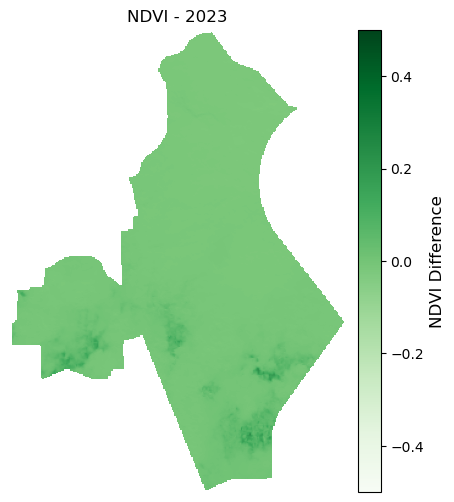

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
import numpy as np

# Set up the figure and axis

ndvi_difference_clipped = ndvi_2024_clipped - ndvi_2023_clipped

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Define a colormap  for NDVI difference
diff_cmap = ListedColormap(plt.cm.Greens(np.linspace(0, 1, 256)))

# Create a single colorbar for the entire animation
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=diff_cmap, norm=plt.Normalize(vmin=-0.5, vmax=0.5)), 
                    ax=ax, orientation="vertical", pad=0.02)
cbar.set_label("NDVI Difference", fontsize=12)


# Define function to update each frame in the animation
def update_frame(i):
    ax.clear()  # Clear the plot for each frame
    if i == 0:
        ax.imshow(ndvi_2023_clipped, cmap='YlGn', vmin=-1, vmax=1)
        ax.set_title("NDVI - 2023")
    elif i == 1:
        ax.imshow(ndvi_2024_clipped, cmap='YlGn', vmin=-1, vmax=1)
        ax.set_title("NDVI - 2024")
    else:
        ax.imshow(ndvi_difference_clipped, cmap='YlGn', vmin=-0.5, vmax=0.5)
        ax.set_title("NDVI Difference (2024 - 2023)")

    ax.axis('off')  # Turn off axis for cleaner visuals
     

# Create the animation object
ani = animation.FuncAnimation(fig, update_frame, frames=3, interval=1000)

# Display the animation inline (for Jupyter Notebooks or IPython)
from IPython.display import HTML
HTML(ani.to_jshtml())









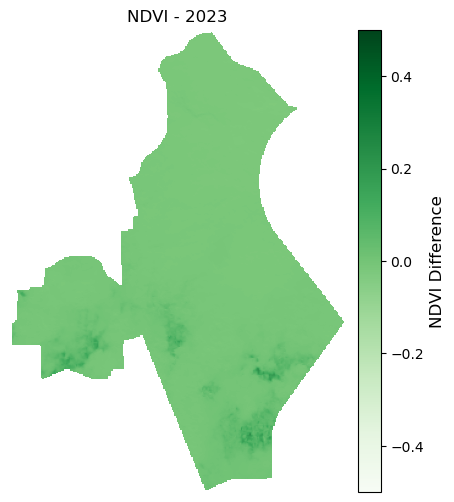

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
import numpy as np
from IPython.display import HTML

# Compute the NDVI difference for 2024 vs. 2023
ndvi_difference_clipped = ndvi_2024_clipped - ndvi_2023_clipped

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Define a colormap for NDVI difference
diff_cmap = ListedColormap(plt.cm.Greens(np.linspace(0, 1, 256)))

# Create a single colorbar for the entire animation
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=diff_cmap, norm=plt.Normalize(vmin=-0.5, vmax=0.5)), 
    ax=ax, orientation="vertical", pad=0.02
)
cbar.set_label("NDVI Difference", fontsize=12)

# Define function to update each frame in the animation
def update_frame(i):
    ax.clear()  # Clear the plot for each frame
    
    if i == 0:
        ax.imshow(ndvi_2023_clipped, cmap='YlGn', vmin=-1, vmax=1)
        ax.set_title("NDVI - 2023")
    elif i == 1:
        ax.imshow(ndvi_2024_clipped, cmap='YlGn', vmin=-1, vmax=1)
        ax.set_title("NDVI - 2024")
    else:
        ax.imshow(ndvi_difference_clipped, cmap=diff_cmap, vmin=-0.5, vmax=0.5)
        ax.set_title("NDVI Difference (2024 - 2023)")
    
    ax.axis('off')  # Turn off axis for cleaner visuals

# Create the animation object
ani = animation.FuncAnimation(fig, update_frame, frames=3, interval=1000)

# Display the animation inline (for Jupyter Notebooks or IPython)
HTML(ani.to_jshtml())
